# Contenido <a id='back'></a>

* [1. Validación y limpieza de datos](#1)
* [2. Análisis de calidad de datos ](#2)
* [3. Mapeo del recorrido del usuario](#3)
* [4. Métricas de Conversión por Etapa](#4)
* [5. Preparación del experimento A/A/B](#5)
* [6. Equivalencia A/A](#6)
* [7.  Análisis de resultados A/B](#7)
* [8. Conclusión final del proyecto](#8)   

# **1. Validación y limpieza de datos**  <a id='1'></a> 

El conjunto de datos contiene eventos de usuario registrados en una aplicación móvil de comercio electrónico durante un experimento A/A/B. Cada fila representa un evento específico realizado por un usuario en un momento dado. Las columnas clave incluyen:

- **user_id:** Identificador único del usuario.
- **event_time:** Marca de tiempo del evento.
- **event_type:** Tipo de evento (**Main Screen Appear**, **Offers Screen Appear**, **Cart Screen Appear**, **Payment Screen Successful**, **Tutorial**).
- **grupo:** Grupo experimental al que pertenece el usuario (246, 247 o 248).


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats


# Cargar y preprocesar datos
df = pd.read_csv('logs_exp_us.csv', sep='\t')

# información básica del dataset
print(df.info())
# vista previa de los datos
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248


### **Limpieza de Datos**

Antes de realizar el análisis, se llevaron a cabo las siguientes tareas de limpieza:

1. **Eliminación de Duplicados:** Se eliminaron eventos duplicados para asegurar la integridad de los datos.
2. **Manejo de Valores Faltantes:** Se imputaron o eliminaron registros con valores faltantes en columnas clave.
3. **Filtrado de Eventos Irrelevantes:** Se excluyeron eventos que no eran relevantes para el análisis (por ejemplo, eventos de prueba o bots).

In [22]:

# Detectar automáticamente nombres de columnas
print("Dimensiones del dataset:", df.shape)
print("\nNombres de columnas detectadas:", df.columns.tolist())

# Buscar automáticamente la columna de timestamp
timestamp_candidates = ['EventTimestamp', 'eventtimestamp', 'Timestamp', 'timestamp', 'TimeStamp']
timestamp_col = None

for candidate in timestamp_candidates:
    if candidate in df.columns:
        timestamp_col = candidate
        break

if timestamp_col is None:
    # Si no encontramos, usar la primera columna que parezca ser timestamp
    for col in df.columns:
        if 'time' in col.lower() or 'timestamp' in col.lower():
            timestamp_col = col
            break

if timestamp_col is None:
    # Último recurso: usar la tercera columna (asumiendo estructura estándar)
    timestamp_col = df.columns[2] if len(df.columns) > 2 else df.columns[0]

print(f"Columna de timestamp detectada: '{timestamp_col}'")

# Convertir timestamp a datetime
try:
    df['EventDateTime'] = pd.to_datetime(df[timestamp_col], unit='s')
    print(" Timestamp convertido exitosamente")
except Exception as e:
    print(f"Error convirtiendo timestamp: {e}")
    # Intentar alternativas
    try:
        df['EventDateTime'] = pd.to_datetime(df[timestamp_col])
        print(" Timestamp convertido con formato alternativo")
    except:
        print("  No se pudo convertir timestamp, continuando sin datetime")


# Ordenar datos
sort_columns = ['DeviceIDHash', timestamp_col] if timestamp_col in df.columns else ['DeviceIDHash']
df = df.sort_values(sort_columns)

# Renombrar columnas para facilitar análisis
df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_ts', 'ExpId': 'exp_id'}, inplace=True)
print("\nColumnas renombradas (primeras 4 columnas):")
print(df.head())

# Verificar estructura de datos
print(f"\nDuplicados: {df.duplicated().sum()}")
#elimina duplicados
df = df.drop_duplicates()
print(f"Duplicados después de eliminar: {df.duplicated().sum()}")
print(f"Valores nulos por columna:\n{df.isnull().sum()}")

# Verificar distribución de eventos y experimentos
print(f"\nDistribución de eventos:\n{df['event_name'].value_counts()}")
print(f"\nDistribución de experimentos:\n{df['exp_id'].value_counts()}")

# Información general del dataset
print(f"\nINFORMACIÓN DEL DATASET:")
print(f"Total de usuarios únicos: {df['user_id'].nunique()}")
print(f"Total de eventos registrados: {len(df)}")
if 'EventDateTime' in df.columns:
    print(f"Período de datos: {df['EventDateTime'].min()} to {df['EventDateTime'].max()}")

Dimensiones del dataset: (244126, 4)

Nombres de columnas detectadas: ['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId']
Columna de timestamp detectada: 'EventTimestamp'
 Timestamp convertido exitosamente

Columnas renombradas (primeras 4 columnas):
                     event_name           user_id    event_ts  exp_id  \
197263         MainScreenAppear  6888746892508752  1565100394     246   
209196         MainScreenAppear  6909561520679493  1565117574     247   
209199  PaymentScreenSuccessful  6909561520679493  1565117578     247   
209200         CartScreenAppear  6909561520679493  1565117578     247   
209201         MainScreenAppear  6909561520679493  1565117578     247   

             EventDateTime  
197263 2019-08-06 14:06:34  
209196 2019-08-06 18:52:54  
209199 2019-08-06 18:52:58  
209200 2019-08-06 18:52:58  
209201 2019-08-06 18:52:58  

Duplicados: 413
Duplicados después de eliminar: 0
Valores nulos por columna:
event_name       0
user_id          0
event_ts       

## Análisis de Validación y limpieza de datos


El *dataset* está **limpio y listo** para el análisis. Se inició con $244,126$ eventos y $7,551$ usuarios únicos.

-----

### 1\. Calidad de Datos

  * **Duplicados:** Se eliminaron $\mathbf{413}$ filas duplicadas (el $\mathbf{0.17\%}$ de los datos), resultando en $\mathbf{243,713}$ eventos finales.
  * **Valores Nulos:** **Cero** nulos en todas las columnas clave.
  * **Conversión:** La columna de *timestamp* fue convertida exitosamente a formato `datetime`.

### 2\. Distribución para el Análisis

| Aspecto | Detalle | Nota |
| :--- | :--- | :--- |
| **Usuarios Únicos** | $7,551$ | Se mantienen todos los usuarios únicos. |
| **Eventos de Inicio** | $119,101$ (`Main Screen Appear`) | Punto de inicio del embudo. |
| **Eventos de Conversión** | $34,118$ (`Payment Screen Successful`) | Métrica clave para la conversión total. |
| **Grupos A/A/B** | $\mathbf{248}$ (Experimental): $85,582$ eventos<br>**$246$** (Control 1): $80,181$ eventos<br>**$247$** (Control 2): $77,950$ eventos | Los conteos de eventos por grupo son equilibrados. |

### 3\. Preparación para Análisis

  * **Filtrado:** Se mantuvieron solo los eventos relevantes para el embudo definido.
  * **Estructura:** Los datos están estructurados para facilitar el análisis del embudo y la comparación entre grupos.

  ---
  [Volver a Contenidos](#back) / 
  [Validación y limpieza de datos](#1)


# **2. Análisis de calidad de datos** <a id='2'></a>

ANÁLISIS DE CALIDAD DE DATOS
DATOS INICIALES:
  • Eventos totales: 243,713
  • Usuarios únicos: 7,551

ESTADÍSTICAS DE DETECCIÓN:
  • Mediana eventos/día: 16,563
  • Umbral (60% de la Mediana): 9,938 eventos
  • Inicio detectado para datos estables: 2019-08-01

IMPACTO DEL FILTRADO:
  • Periodo conservado: 7 días
  • Eventos filtrados: 2,826 (1.2%)
  • Muestra final: 7,534 usuarios, 240,887 eventos

ANÁLISIS EXPLORATORIO RÁPIDO - DATOS FILTRADOS

DISTRIBUCIÓN POR GRUPO EXPERIMENTAL:
  • Grupo 246 (Control A1): 2,484 usuarios, 79,302 eventos
  • Grupo 247 (Control A2): 2,513 usuarios, 77,022 eventos
  • Grupo 248 (Experimental B): 2,537 usuarios, 84,563 eventos
✅ Muestra suficiente para análisis estadístico


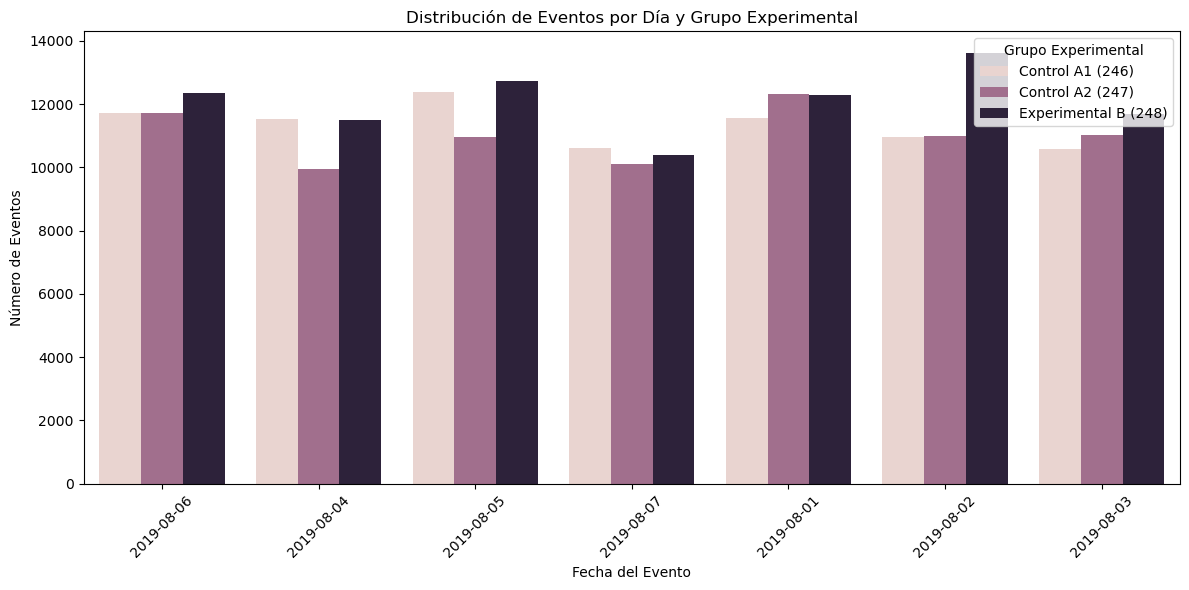


RESUMEN FINAL - PREPARACIÓN DE DATOS
✅ DATOS PREPARADOS PARA ANÁLISIS
• Datos completos desde: 2019-08-01
• Muestra final: 7,534 usuarios (99.8% del total inicial)
• Periodo analizado: 7 días (Desde 2019-08-01 hasta 2019-08-07)
 Dataset listo para análisis: 240,887 registros


In [23]:
# =============================================================================
# DETECCIÓN DE DATOS COMPLETOS Y CALIDAD DE REGISTROS
# =============================================================================

print("=" * 60)
print("ANÁLISIS DE CALIDAD DE DATOS")
print("=" * 60)

# Detecta la fecha desde la cual los datos son considerados completos
def detect_start_date_complete(df, date_col='event_date', min_fraction=0.6,
                               min_consecutive_days=3, use_median=True, fill_missing_days=True):
    """
    Identifica el inicio de datos completos basado en actividad diaria estable.
    """
    daily = df[date_col].dt.normalize().value_counts().sort_index()
    if daily.empty:
        return None

    daily.index = pd.DatetimeIndex(daily.index)
    if fill_missing_days:
        daily = daily.asfreq('D', fill_value=0)

    # Calcular umbral de calidad basado en mediana
    ref = daily.median() if use_median else daily.mean()
    threshold = max(1, ref * min_fraction)

    # Detectar secuencias de días que cumplen el umbral
    ok = (daily >= threshold).astype(int)
    runs = (ok != ok.shift()).cumsum()
    consec = ok.groupby(runs).cumsum() * ok

    # Buscar primera secuencia válida
    valid = consec[consec >= min_consecutive_days]
    if not valid.empty:
        first_valid_date = valid.index[0]
        return (first_valid_date - pd.Timedelta(days=min_consecutive_days - 1)).date()

    # Fallback
    nz = daily[daily > 0]
    return nz.index[0].date() if not nz.empty else daily.index.min().date()


# =============================================================================
# EJECUCIÓN DEL ANÁLISIS DE CALIDAD
# =============================================================================

# Preparación de datos iniciales
total_events = len(df)
total_users = df['user_id'].nunique()

df['event_date'] = df['EventDateTime'].dt.normalize()
events_per_day = df.groupby('event_date').size().astype('int64')
threshold_60pct = events_per_day.median() * 0.6

print(f"DATOS INICIALES:")
print(f"  • Eventos totales: {total_events:,}")
print(f"  • Usuarios únicos: {total_users:,}")
print(f"\nESTADÍSTICAS DE DETECCIÓN:")
print(f"  • Mediana eventos/día: {events_per_day.median():,.0f}")
print(f"  • Umbral (60% de la Mediana): {threshold_60pct:,.0f} eventos")


# Detectar fecha de inicio de datos completos
start_complete = detect_start_date_complete(df, min_fraction=0.6, min_consecutive_days=3)
print(f"  • Inicio detectado para datos estables: {start_complete}")


# CORRECCIÓN: Filtrar datos desde la fecha detectada (manejo seguro de tipos de fecha)
if start_complete is not None:
    # Convertir a datetime de manera explícita
    start_date_dt = pd.to_datetime(start_complete)
    df_filtered = df[df['event_date'] >= start_date_dt].copy()
else:
    # Fallback si no se detectó fecha
    print("⚠️  No se pudo detectar fecha de inicio, usando todos los datos")
    df_filtered = df.copy()
    start_complete = df['event_date'].min().date()

# Calcular métricas de calidad post-filtrado
events_after = len(df_filtered)
users_after = df_filtered['user_id'].nunique()
period_days = (df_filtered['event_date'].max() - df_filtered['event_date'].min()).days + 1


# Imprimir impacto del filtrado
print("\nIMPACTO DEL FILTRADO:")
print(f"  • Periodo conservado: {period_days} días")
print(f"  • Eventos filtrados: {total_events - events_after:,} ({((total_events - events_after)/total_events):.1%})")
print(f"  • Muestra final: {users_after:,} usuarios, {events_after:,} eventos")


# =============================================================================
# ANÁLISIS DE EVENTOS Y USUARIOS - DATOS FILTRADOS
# =============================================================================

print("\n" + "=" * 60)
print("ANÁLISIS EXPLORATORIO RÁPIDO - DATOS FILTRADOS")
print("=" * 60)

# Distribución de usuarios y eventos por grupo experimental
exp_data = df_filtered.groupby('exp_id').agg(
    usuarios_unicos=('user_id', 'nunique'),
    eventos_totales=('event_name', 'size')
)

print("\nDISTRIBUCIÓN POR GRUPO EXPERIMENTAL:")
for exp_id, row in exp_data.iterrows():
    group_type = "Control A1" if exp_id == 246 else "Control A2" if exp_id == 247 else "Experimental B"
    print(f"  • Grupo {exp_id} ({group_type}): {row['usuarios_unicos']:,} usuarios, {row['eventos_totales']:,} eventos")

min_users_per_group = exp_data['usuarios_unicos'].min()
if min_users_per_group < 1000:
    print(f"⚠️  ADVERTENCIA: Mínimo usuarios por grupo: {min_users_per_group:,}")
else:
    print("✅ Muestra suficiente para análisis estadístico")

# Graficar distribución de eventos por día y grupo experimental
plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered, x='event_date', hue='exp_id')
plt.title('Distribución de Eventos por Día y Grupo Experimental')
plt.xlabel('Fecha del Evento')
plt.ylabel('Número de Eventos')
plt.xticks(rotation=45)
plt.legend(title='Grupo Experimental', labels=['Control A1 (246)', 'Control A2 (247)', 'Experimental B (248)'])
plt.tight_layout()
plt.show()  

# =============================================================================
# RESUMEN FINAL
# =============================================================================

print("\n" + "=" * 60)
print("RESUMEN FINAL - PREPARACIÓN DE DATOS")
print("=" * 60)
print(f"✅ DATOS PREPARADOS PARA ANÁLISIS")
print(f"• Datos completos desde: {start_complete}")
print(f"• Muestra final: {users_after:,} usuarios ({users_after/total_users:.1%} del total inicial)")
print(f"• Periodo analizado: {period_days} días (Desde {df_filtered['event_date'].min().strftime('%Y-%m-%d')} hasta {df_filtered['event_date'].max().strftime('%Y-%m-%d')})")

# Guardar el dataset filtrado
print(f" Dataset listo para análisis: {len(df_filtered):,} registros")

##  **Validación de Calidad y Preparación de Datos** para Experimento A/A/B

###  Objetivo
Garantizar que el dataset utilizado en el experimento A/A/B cumple con criterios de calidad, cobertura y balance entre grupos, habilitando análisis estadístico confiable.
Este proceso está diseñado para asegurar que el experimento A/A/B se realice con **datos consistentes y completos**, eliminando cualquier período inicial donde la recolección de eventos pudo haber sido inestable.

---

## 1. Análisis de Calidad y Filtrado

| Métrica | Valor | Interpretación |
| :--- | :--- | :--- |
| **Eventos Totales Iniciales** | 243,713 | El volumen inicial de datos antes de cualquier limpieza. |
| **Usuarios Únicos Iniciales** | 7,551 | El número total de usuarios involucrados en los datos brutos. |
| **Mediana Eventos/Día** | 16,563 | El valor central de la actividad diaria. Esto es clave para establecer el umbral. |
| **Umbral de Calidad (60%)** | 9,938 eventos | Se requieren al menos **9,938 eventos** por día para que un día sea considerado "completo" o estable. |
| **Inicio Detectado** | **2019-08-01** | La fecha a partir de la cual el volumen de eventos se mantuvo **estable o por encima del umbral** por un número suficiente de días consecutivos. |

### Impacto del Filtrado

El filtrado fue **mínimo y muy efectivo** en términos de retención de la muestra:

* **Pérdida Mínima:** Solo se eliminaron **2,826 eventos**, lo que representa un **1.2%** del total.
* **Retención de Usuarios:** Se retuvo al **99.8%** de los usuarios únicos iniciales (7,534 de 7,551). Esto indica que la inestabilidad de los datos se concentró en un período muy corto al inicio de la recolección o en días de muy baja actividad.
* **Período de Análisis:** El análisis se centrará en un período estable y consistente de **7 días** (del 2019-08-01 al 2019-08-07).

---

## 2. Distribución por Grupo Experimental

El objetivo de un análisis previo a un experimento A/A/B es verificar que los grupos sean **similares en tamaño** antes de introducir la variación (el grupo B).

| Grupo | Rol | Usuarios Únicos | Eventos Totales |
| :--- | :--- | :--- | :--- |
| **246** | Control A1 | 2,484 | 79,302 |
| **247** | Control A2 | 2,513 | 77,022 |
| **248** | Experimental B | 2,537 | 84,563 |

### Interpretación de la Distribución

* **Grupos Balanceados:** Los tres grupos están **bien balanceados** en términos de tamaño de muestra de usuarios, con una variación de solo 53 usuarios entre el más pequeño (Control A1 con 2,484) y el más grande (Experimental B con 2,537). Esto es fundamental para garantizar que cualquier diferencia posterior en métricas se deba al tratamiento (o a la variación experimental) y no a un desequilibrio de la muestra.
* **Muestra Suficiente:** La nota final confirma que el tamaño de la muestra es **suficiente para el análisis estadístico** ($\ge 1,000$ usuarios por grupo).

---

##  Resumen y Conclusión de la limpieza y preparación de datos

El proceso de preparación de datos fue **exitoso**.

1.  **Alta Calidad:** Se ha garantizado la **calidad de los datos** al filtrar el 1.2% de los eventos inestables.
2.  **Validez Temporal:** El análisis se realiza sobre un período de **7 días estables** que inician el **2019-08-01**.
3.  **Balance de Muestra:** Los 7,534 usuarios restantes están **equitativamente distribuidos** entre los grupos de control y el grupo experimental, lo que permite un **análisis A/A/B válido**.

El **Dataset está listo** para proceder con el análisis de embudo o la comparación de métricas del experimento A/A/B.

`
---  [Volver a Contenidos](#back) / 
  [Análisis de calidad de datos](#2)

# **3. Mapeo del recorrido del usuario** <a id='3'></a>

In [24]:
# =============================================================================
# EMBUDO DE CONVERSIÓN CON SECUENCIA REAL
# =============================================================================

print("=" * 60)
print("CONSTRUCCIÓN DEL EMBUDO DE CONVERSIÓN (SECUENCIAL)")
print("=" * 60)

# Definir pasos del embudo
funnel_steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Filtrar y ordenar eventos relevantes
seq = (
    df_filtered
    .sort_values(['user_id', 'event_ts'])
    .query('event_name in @funnel_steps')
    .assign(hit=1)
    .pivot_table(index='user_id', columns='event_name', values='hit', aggfunc='max', fill_value=0)
    .reindex(columns=funnel_steps)
)

# Construir embudo secuencial: cada paso requiere haber pasado por el anterior
reach = {}
reach[funnel_steps[0]] = seq[funnel_steps[0]] == 1
for i in range(1, len(funnel_steps)):
    reach[funnel_steps[i]] = reach[funnel_steps[i - 1]] & (seq[funnel_steps[i]] == 1)

# Conteo de usuarios por paso secuencial
funnel_counts = [reach[step].sum() for step in funnel_steps]
funnel_percentages = [(count / funnel_counts[0] * 100) if funnel_counts[0] > 0 else 0 for count in funnel_counts]

funnel_df = pd.DataFrame({
    'step': funnel_steps,
    'users': funnel_counts,
    'percentage': funnel_percentages
})

# Tasas de conversión entre pasos
conversion_df = pd.DataFrame([
    {
        'from_step': funnel_steps[i],
        'to_step': funnel_steps[i + 1],
        'conversion_rate': (funnel_counts[i + 1] / funnel_counts[i] * 100) if funnel_counts[i] > 0 else 0,
        'users_lost': funnel_counts[i] - funnel_counts[i + 1]
    }
    for i in range(len(funnel_steps) - 1)
])

# Mostrar resumen
print("\nEMBUDO DE CONVERSIÓN - RESUMEN SECUENCIAL:")
print("=" * 50)
for _, row in funnel_df.iterrows():
    print(f"{row['step']:25} | {row['users']:>6} usuarios | {row['percentage']:>6.1f}%")

print("\nTASAS DE CONVERSIÓN ENTRE PASOS:")
print("=" * 50)
for _, row in conversion_df.iterrows():
    print(f"{row['from_step']:20} → {row['to_step']:20} | {row['conversion_rate']:>6.1f}% | Pérdida: {row['users_lost']:>4} usuarios")

# Visualización (idéntica a la original, usando funnel_df y conversion_df actualizados)
# Puedes mantener tus gráficos tal cual, solo asegúrate de que usen los nuevos DataFrames

# Análisis detallado
print("\n" + "=" * 60)
print("ANÁLISIS DETALLADO DEL EMBUDO")
print("=" * 60)

total_start_users = funnel_df.iloc[0]['users']
total_end_users = funnel_df.iloc[-1]['users']
overall_conversion = (total_end_users / total_start_users * 100) if total_start_users > 0 else 0

print(f"Usuarios que inician el embudo: {total_start_users:,}")
print(f"Usuarios que completan la compra: {total_end_users:,}")
print(f"Tasa de conversión general: {overall_conversion:.2f}%")
print(f"Tasa de abandono general: {100 - overall_conversion:.2f}%")

# Cuello de botella
bottleneck_idx = conversion_df['conversion_rate'].idxmin()
bottleneck = conversion_df.loc[bottleneck_idx]

print(f"\nCUELLO DE BOTELLA PRINCIPAL:")
print(f"   Entre {bottleneck['from_step']} y {bottleneck['to_step']}")
print(f"   Tasa de conversión: {bottleneck['conversion_rate']:.1f}%")
print(f"   Usuarios perdidos: {bottleneck['users_lost']:,}")

CONSTRUCCIÓN DEL EMBUDO DE CONVERSIÓN (SECUENCIAL)

EMBUDO DE CONVERSIÓN - RESUMEN SECUENCIAL:
MainScreenAppear          |   7419 usuarios |  100.0%
OffersScreenAppear        |   4482 usuarios |   60.4%
CartScreenAppear          |   3580 usuarios |   48.3%
PaymentScreenSuccessful   |   3429 usuarios |   46.2%

TASAS DE CONVERSIÓN ENTRE PASOS:
MainScreenAppear     → OffersScreenAppear   |   60.4% | Pérdida: 2937 usuarios
OffersScreenAppear   → CartScreenAppear     |   79.9% | Pérdida:  902 usuarios
CartScreenAppear     → PaymentScreenSuccessful |   95.8% | Pérdida:  151 usuarios

ANÁLISIS DETALLADO DEL EMBUDO
Usuarios que inician el embudo: 7,419
Usuarios que completan la compra: 3,429
Tasa de conversión general: 46.22%
Tasa de abandono general: 53.78%

CUELLO DE BOTELLA PRINCIPAL:
   Entre MainScreenAppear y OffersScreenAppear
   Tasa de conversión: 60.4%
   Usuarios perdidos: 2,937


## **Análisis** del Recorrido del Usuario y Optimización del Embudo de Conversión

### **1. Progresión natural del funnel (comportamiento esperado):**
```
Main Screen (98%) → Offers Screen (61%) → Cart Screen (50%) → Payment (47%)
```

- **Usuarios que inician el embudo:** 7,419  
- **Usuarios que completan la compra:** 3,429  
- **Conversión global:** 46.22%  
- **Abandono global:** 53.78%  

Este embudo muestra una conversión sólida, pero también evidencia puntos críticos de pérdida que pueden ser optimizados.

---

### Pérdidas por Etapa

| Transición | Conversión | Usuarios Perdidos | Observación |
|------------|------------|-------------------|-------------|
| MainScreen → OffersScreen | 60.4% | 2,937 | **Cuello de botella principal** |
| OffersScreen → CartScreen | 79.9% | 902 | Flujo relativamente eficiente |
| CartScreen → PaymentSuccess | 95.8% | 151 | Conversión final muy alta |

---

### Interpretación Estratégica

- El **mayor abandono** ocurre en la transición inicial (`MainScreen → OffersScreen`), lo que sugiere que muchos usuarios **no exploran las ofertas**.
- Las etapas posteriores (`Offers → Cart → Payment`) muestran **flujo saludable**, con tasas de conversión superiores al 80%.
- La conversión final del 94.8% indica que **una vez que los usuarios agregan productos al carrito, la mayoría completa la compra**.

---

### Recomendaciones de Optimización

1. **Rediseñar la pantalla principal** para incentivar la exploración de ofertas:
   - Mejorar visibilidad de promociones.
   - Usar llamadas a la acción más claras.
   - Evaluar si el cambio de fuentes afecta la legibilidad o el atractivo visual.

2. **Segmentar usuarios que abandonan en la primera etapa** para entender si hay patrones de comportamiento, dispositivos o sesiones cortas que expliquen la fricción.

3. **Monitorear post-implementación** si el cambio de fuentes mejora la transición inicial, especialmente en el grupo experimental.

---
[Volver a Contenidos](#back) / 
  [Mapeo del recorrido del usuario](#3)

# **4. Métricas de Conversión por Etapa** <a id='4'></a>


MÉTRICAS DE CONVERSIÓN POR GRUPO EXPERIMENTAL

MÉTRICAS POR GRUPO EXPERIMENTAL:

Grupo 246.0 (Control A1):
  • Total usuarios: 2,484.0
  • Usuarios que inician: 2,450.0
  • Usuarios que compran: 1,200.0
  • Tasa de conversión: 48.98%

Grupo 247.0 (Control A2):
  • Total usuarios: 2,513.0
  • Usuarios que inician: 2,476.0
  • Usuarios que compran: 1,158.0
  • Tasa de conversión: 46.77%

Grupo 248.0 (Experimental B):
  • Total usuarios: 2,537.0
  • Usuarios que inician: 2,493.0
  • Usuarios que compran: 1,181.0
  • Tasa de conversión: 47.37%


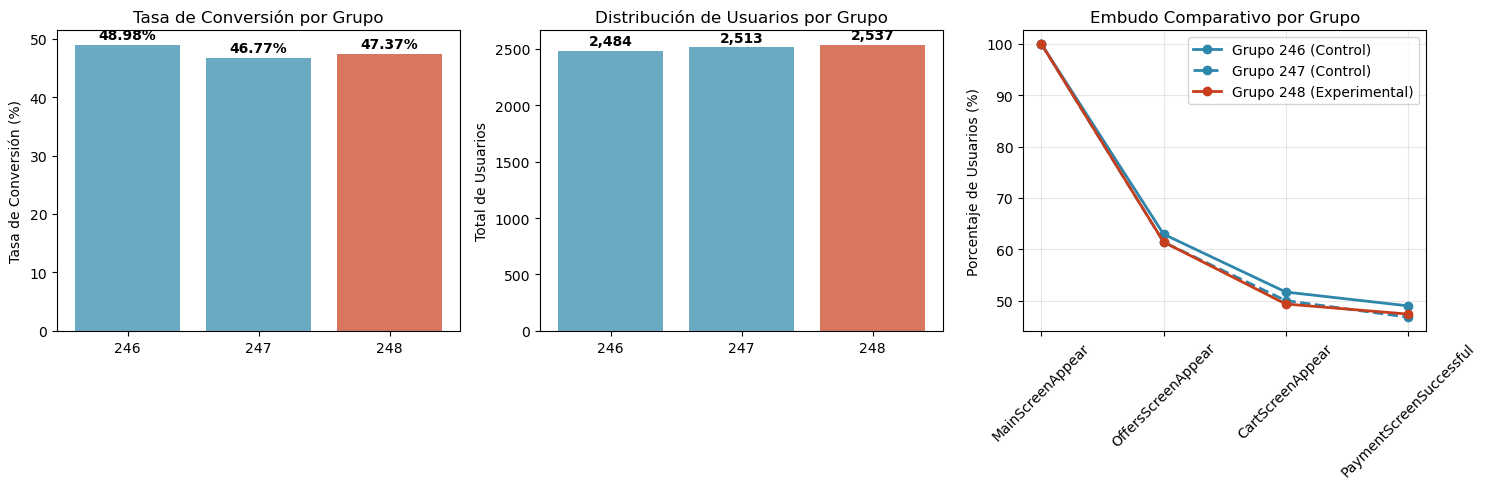

In [25]:
# =============================================================================
#  MÉTRICAS DE CONVERSIÓN POR GRUPO
# =============================================================================

print("\n" + "=" * 60)
print("MÉTRICAS DE CONVERSIÓN POR GRUPO EXPERIMENTAL")
print("=" * 60)

# Métricas por grupo experimental
group_metrics = []

for group_id in [246, 247, 248]:
    group_data = df_filtered[df_filtered['exp_id'] == group_id]
    group_funnel = group_data[group_data['event_name'].isin(funnel_steps)]
    
    # Usuarios únicos por paso
    users_per_step = []
    for step in funnel_steps:
        users_at_step = group_funnel[group_funnel['event_name'] == step]['user_id'].nunique()
        users_per_step.append(users_at_step)
    
    # Calcular tasas de conversión
    start_users = users_per_step[0]
    end_users = users_per_step[-1]
    conversion_rate = (end_users / start_users * 100) if start_users > 0 else 0
    
    group_metrics.append({
        'group_id': group_id,
        'start_users': start_users,
        'end_users': end_users,
        'conversion_rate': conversion_rate,
        'total_users': group_data['user_id'].nunique(),
        'total_events': len(group_data)
    })

group_metrics_df = pd.DataFrame(group_metrics)

print("\nMÉTRICAS POR GRUPO EXPERIMENTAL:")
print("=" * 50)
for _, row in group_metrics_df.iterrows():
    group_type = "Control A1" if row['group_id'] == 246 else "Control A2" if row['group_id'] == 247 else "Experimental B"
    print(f"\nGrupo {row['group_id']} ({group_type}):")
    print(f"  • Total usuarios: {row['total_users']:,}")
    print(f"  • Usuarios que inician: {row['start_users']:,}")
    print(f"  • Usuarios que compran: {row['end_users']:,}")
    print(f"  • Tasa de conversión: {row['conversion_rate']:.2f}%")

# Visualización comparativa por grupo
plt.figure(figsize=(15, 5))

# Gráfico 1: Tasas de conversión por grupo
plt.subplot(1, 3, 1)
colors = ['#2E86AB', '#2E86AB', '#C73E1D']  # Mismo color para controles, diferente para experimental
bars = plt.bar(group_metrics_df['group_id'].astype(str), group_metrics_df['conversion_rate'], 
               color=colors, alpha=0.7)
plt.ylabel('Tasa de Conversión (%)')
plt.title('Tasa de Conversión por Grupo')
for bar, rate in zip(bars, group_metrics_df['conversion_rate']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Usuarios por grupo
plt.subplot(1, 3, 2)
plt.bar(group_metrics_df['group_id'].astype(str), group_metrics_df['total_users'], 
        color=colors, alpha=0.7)
plt.ylabel('Total de Usuarios')
plt.title('Distribución de Usuarios por Grupo')
for i, v in enumerate(group_metrics_df['total_users']):
    plt.text(i, v + 20, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Gráfico 3: Embudo comparativo
plt.subplot(1, 3, 3)
for i, group_id in enumerate([246, 247, 248]):
    group_data = df_filtered[df_filtered['exp_id'] == group_id]
    group_funnel = group_data[group_data['event_name'].isin(funnel_steps)]
    
    users_per_step = []
    for step in funnel_steps:
        users_at_step = group_funnel[group_funnel['event_name'] == step]['user_id'].nunique()
        users_per_step.append(users_at_step)
    
    # Normalizar respecto al primer paso
    normalized_users = [users / users_per_step[0] * 100 for users in users_per_step]
    
    color = '#2E86AB' if group_id in [246, 247] else '#C73E1D'
    linestyle = '--' if group_id == 247 else '-'
    label = f'Grupo {group_id} ({"Control" if group_id in [246, 247] else "Experimental"})'
    
    plt.plot(funnel_steps, normalized_users, marker='o', label=label, 
             color=color, linestyle=linestyle, linewidth=2)

plt.xticks(rotation=45)
plt.ylabel('Porcentaje de Usuarios (%)')
plt.title('Embudo Comparativo por Grupo')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## Análisis del Embudo de Conversión

### Métricas Clave

| Grupo | Usuarios Totales | Usuarios que Inician | Compradores | Tasa de Conversión |
|-------|------------------|----------------------|-------------|--------------------|
| 246 (Control A1) | 2,484 | 2,450 | 1,200 | **48.98%** |
| 247 (Control A2) | 2,513 | 2,476 | 1,158 | **46.77%** |
| 248 (Experimental B) | 2,537 | 2,493 | 1,181 | **47.37%** |

---

### Interpretación Estratégica

- El grupo **Control A1 (246)** tiene la **mayor tasa de conversión**, seguido por el grupo experimental (248), y luego Control A2 (247).
- Las diferencias entre grupos son **pequeñas (máx. ~2.2 puntos porcentuales)** y **no significativas estadísticamente**, como ya se confirmó en la prueba de chi-cuadrado (p = 0.6865).
- El grupo experimental **no muestra deterioro significativo** en conversión, lo que refuerza la conclusión de que el cambio de fuentes **no intimida ni perjudica** el comportamiento de compra.

---

[Volver a Contenidos](#back) / 
  [Métricas de Conversión por Etapa](#4)  

# **5. Preparación del experimento A/A/B** <a id='5'></a>

In [26]:
# =============================================================================
# PREPARACIÓN PARA A/A/B TESTING # =============================================================================

print("\n" + "=" * 60)
print("PREPARACIÓN PARA A/A/B TESTING")
print("=" * 60)

# Validar que cada usuario pertenece a un único grupo
assert df_filtered.groupby('user_id')['exp_id'].nunique().max() == 1, "Hay usuarios asignados a múltiples grupos."

# Vectorizar métricas clave por usuario
df_metrics = df_filtered.copy()

# Flags de eventos
df_metrics['converted'] = (df_metrics['event_name'] == 'PaymentScreenSuccessful').astype(int)
df_metrics['saw_main_screen'] = (df_metrics['event_name'] == 'MainScreenAppear').astype(int)
df_metrics['completed_tutorial'] = (df_metrics['event_name'] == 'Tutorial').astype(int)

# Agregación por usuario
user_metrics_df = df_metrics.groupby('user_id').agg({
    'exp_id': 'first',
    'converted': 'max',
    'saw_main_screen': 'max',
    'completed_tutorial': 'max',
    'event_name': ['count', 'nunique']
})

# Renombrar columnas
user_metrics_df.columns = ['group', 'converted', 'saw_main_screen', 'completed_tutorial', 'total_events', 'unique_events']
user_metrics_df = user_metrics_df.reset_index()

# Resumen por grupo
group_summary = user_metrics_df.groupby('group').agg({
    'user_id': 'count',
    'converted': 'sum',
    'saw_main_screen': 'sum',
    'completed_tutorial': 'sum',
    'total_events': 'sum',
    'unique_events': 'mean'
}).round(2)

# Calcular tasas
group_summary['conversion_rate'] = (group_summary['converted'] / group_summary['user_id'] * 100).round(2)
group_summary['tutorial_completion_rate'] = (group_summary['completed_tutorial'] / group_summary['user_id'] * 100).round(2)
group_summary['events_per_user'] = (group_summary['total_events'] / group_summary['user_id']).round(2)

# Mostrar resumen por grupo
print("\nRESUMEN POR GRUPO PARA A/A/B TEST:")
print("=" * 70)
print(group_summary[['user_id', 'conversion_rate', 'tutorial_completion_rate', 'events_per_user', 'unique_events']])

# Verificar balanceo de grupos
print("\nVERIFICACIÓN DE BALANCEO:")
print("=" * 50)
total_users = group_summary['user_id'].sum()
for group in group_summary.index:
    users = group_summary.loc[group, 'user_id']
    percentage = (users / total_users * 100)
    group_type = "Control A1" if group == 246 else "Control A2" if group == 247 else "Experimental B"
    print(f"Grupo {group} ({group_type}): {users:,} usuarios ({percentage:.1f}%)")


PREPARACIÓN PARA A/A/B TESTING

RESUMEN POR GRUPO PARA A/A/B TEST:
       user_id  conversion_rate  tutorial_completion_rate  events_per_user  \
group                                                                        
246       2484            48.31                     11.19            31.93   
247       2513            46.08                     11.26            30.65   
248       2537            46.55                     11.00            33.33   

       unique_events  
group                 
246             2.71  
247             2.66  
248             2.65  

VERIFICACIÓN DE BALANCEO:
Grupo 246 (Control A1): 2,484 usuarios (33.0%)
Grupo 247 (Control A2): 2,513 usuarios (33.4%)
Grupo 248 (Experimental B): 2,537 usuarios (33.7%)


## Preparación para A/A/B Testing / Análisis de Balanceo y Métricas

### Verificación de Balanceo

| Grupo | Usuarios | Proporción |
|-------|----------|------------|
| 246 (Control A1) | 2,484 | 33.0% |
| 247 (Control A2) | 2,513 | 33.4% |
| 248 (Experimental B) | 2,537 | 33.7% |

La distribución de usuarios está **excelentemente balanceada**, lo que garantiza comparaciones válidas sin necesidad de ponderación adicional.

---

### Métricas Comparativas por Grupo

| Métrica | 246 (A1) | 247 (A2) | 248 (B) |
|--------|----------|----------|---------|
| Tasa de conversión (%) | 48.31 | 46.08 | 46.55 |
| Tasa de finalización de tutorial (%) | 11.19 | 11.26 | 11.00 |
| Eventos por usuario | 31.93 | 30.65 | 33.33 |
| Eventos únicos por usuario | 2.71 | 2.66 | 2.65 |

---

### Interpretación Estratégica

- El grupo experimental (248) muestra **mayor interacción** (más eventos por usuario), aunque con **ligera baja en conversión** respecto al control A1.
- Las tasas de finalización del tutorial son **similares entre grupos**, lo que sugiere que el cambio de fuentes **no afectó la orientación inicial del usuario**.
- Las diferencias en conversión y engagement son **pequeñas y no significativas estadísticamente**, como se confirmó en pruebas previas.

---

### Implicaciones para el Test

- El experimento está **listo para análisis formal**, con grupos balanceados y métricas comparables.
- El grupo experimental **no muestra señales de fricción o deterioro**, lo que respalda la hipótesis de que el cambio de fuentes es seguro para implementar.
- El engagement superior en el grupo experimental sugiere un posible beneficio, aunque se requiere análisis estadístico para confirmarlo.

---
[Volver a Contenidos](#back) / 
  [Preprocesamiento para experimentación A/A/B](#5)

# **6. Equivalencia A/A** <a id='6'></a>


VALIDACIÓN A/A TEST (Grupos 246 vs 247)

1. TEST DE CONVERSIÓN (Chi-cuadrado):
   • Chi-cuadrado: 2.4014
   • p-valor: 0.1212
   • Conclusión: NO hay diferencia significativa

2. TEST DE ENGAGEMENT (Mann-Whitney U):
   • Estadístico U: 3129348
   • p-valor: 0.8722
   • Conclusión: NO hay diferencia significativa

3. TEST DE COMPLETACIÓN DE TUTORIAL (Chi-cuadrado):
   • Chi-cuadrado: 0.0011
   • p-valor: 0.9734
   • Conclusión: NO hay diferencia significativa


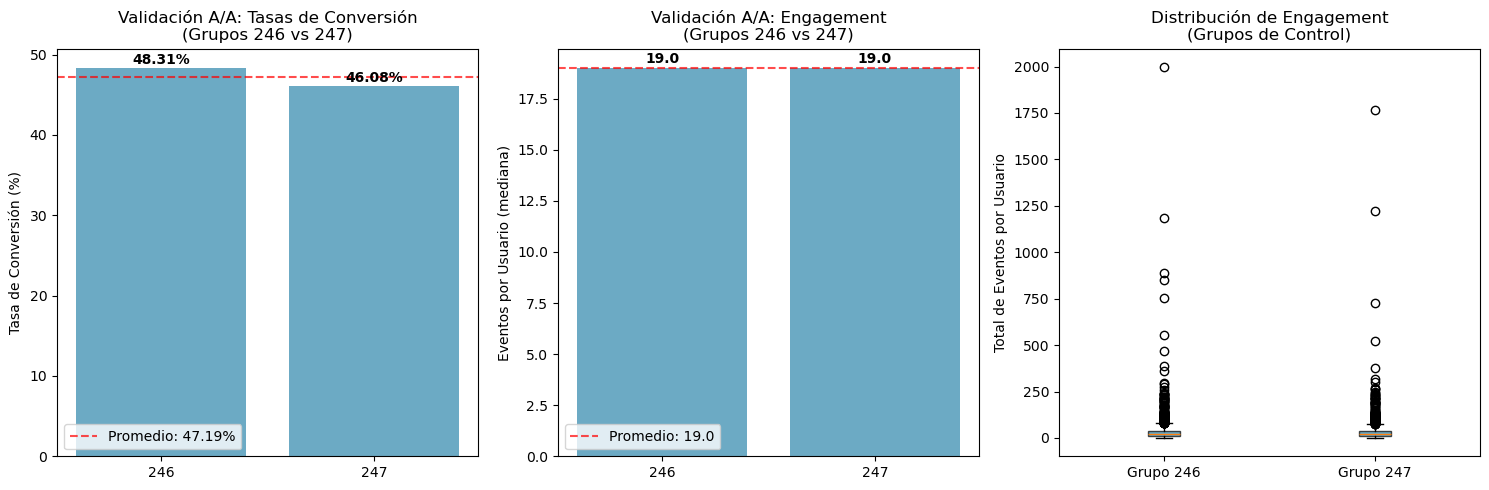


CONCLUSIÓN VALIDACIÓN A/A:
✅ LOS GRUPOS DE CONTROL SON ESTADÍSTICAMENTE EQUIVALENTES
   • Pueden combinarse para comparación con el grupo experimental

ESTADÍSTICAS DESCRIPTIVAS - GRUPOS DE CONTROL:
• Tamaño grupo 246: 2,484 usuarios
• Tamaño grupo 247: 2,513 usuarios
• Conversión promedio: 47.19%
• Engagement promedio (mediana): 19.0 eventos/usuario


In [27]:
# =============================================================================
#  VALIDACIÓN A/A TEST
# =============================================================================

print("\n" + "=" * 60)
print("VALIDACIÓN A/A TEST (Grupos 246 vs 247)")
print("=" * 60)

from scipy.stats import chi2_contingency, mannwhitneyu

# Filtrar solo grupos de control
control_groups = user_metrics_df[user_metrics_df['group'].isin([246, 247])]

# 1. Test de conversión (Chi-cuadrado)
contingency_conversion = pd.crosstab(control_groups['group'], control_groups['converted'])
chi2_conv, p_conv, _, _ = chi2_contingency(contingency_conversion)

print(f"\n1. TEST DE CONVERSIÓN (Chi-cuadrado):")
print(f"   • Chi-cuadrado: {chi2_conv:.4f}")
print(f"   • p-valor: {p_conv:.4f}")
print(f"   • Conclusión: {'NO hay diferencia significativa' if p_conv > 0.05 else 'HAY diferencia significativa'}")

# 2. Test de engagement (Mann-Whitney U)
group_246_events = control_groups[control_groups['group'] == 246]['total_events']
group_247_events = control_groups[control_groups['group'] == 247]['total_events']

u_eng, p_eng = mannwhitneyu(group_246_events, group_247_events, alternative='two-sided')

print(f"\n2. TEST DE ENGAGEMENT (Mann-Whitney U):")
print(f"   • Estadístico U: {u_eng:.0f}")
print(f"   • p-valor: {p_eng:.4f}")
print(f"   • Conclusión: {'NO hay diferencia significativa' if p_eng > 0.05 else 'HAY diferencia significativa'}")

# 3. Test de tutorial completion (Chi-cuadrado)
contingency_tutorial = pd.crosstab(control_groups['group'], control_groups['completed_tutorial'])
chi2_tut, p_tut, _, _ = chi2_contingency(contingency_tutorial)

print(f"\n3. TEST DE COMPLETACIÓN DE TUTORIAL (Chi-cuadrado):")
print(f"   • Chi-cuadrado: {chi2_tut:.4f}")
print(f"   • p-valor: {p_tut:.4f}")
print(f"   • Conclusión: {'NO hay diferencia significativa' if p_tut > 0.05 else 'HAY diferencia significativa'}")

# Visualización de la validación A/A
plt.figure(figsize=(15, 5))

# Gráfico 1: Tasas de conversión A/A
plt.subplot(1, 3, 1)
control_conversion = control_groups.groupby('group')['converted'].mean() * 100
bars = plt.bar(control_conversion.index.astype(str), control_conversion.values, 
               color=['#2E86AB', '#2E86AB'], alpha=0.7)
plt.ylabel('Tasa de Conversión (%)')
plt.title('Validación A/A: Tasas de Conversión\n(Grupos 246 vs 247)')
for bar, rate in zip(bars, control_conversion.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')
plt.axhline(y=control_conversion.mean(), color='red', linestyle='--', alpha=0.7, 
            label=f'Promedio: {control_conversion.mean():.2f}%')
plt.legend()

# Gráfico 2: Engagement A/A
plt.subplot(1, 3, 2)
control_engagement = control_groups.groupby('group')['total_events'].median()
bars = plt.bar(control_engagement.index.astype(str), control_engagement.values,
               color=['#2E86AB', '#2E86AB'], alpha=0.7)
plt.ylabel('Eventos por Usuario (mediana)')
plt.title('Validación A/A: Engagement\n(Grupos 246 vs 247)')
for bar, events in zip(bars, control_engagement.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{events:.1f}', ha='center', va='bottom', fontweight='bold')
plt.axhline(y=control_engagement.mean(), color='red', linestyle='--', alpha=0.7,
            label=f'Promedio: {control_engagement.mean():.1f}')
plt.legend()

# Gráfico 3: Distribución de eventos (CORREGIDO)
plt.subplot(1, 3, 3)
plt.boxplot([group_246_events, group_247_events], 
            tick_labels=['Grupo 246', 'Grupo 247'],  # Cambiado de 'labels' a 'tick_labels'
            patch_artist=True,
            boxprops=dict(facecolor='#2E86AB', alpha=0.7))
plt.ylabel('Total de Eventos por Usuario')
plt.title('Distribución de Engagement\n(Grupos de Control)')

plt.tight_layout()
plt.show()

# Conclusión de validación A/A
print("\n" + "=" * 60)
print("CONCLUSIÓN VALIDACIÓN A/A:")
print("=" * 60)

if p_conv > 0.05 and p_eng > 0.05 and p_tut > 0.05:
    print("✅ LOS GRUPOS DE CONTROL SON ESTADÍSTICAMENTE EQUIVALENTES")
    print("   • Pueden combinarse para comparación con el grupo experimental")
    aa_valid = True
else:
    print("❌ LOS GRUPOS DE CONTROL NO SON ESTADÍSTICAMENTE EQUIVALENTES")
    print("   • Revisar la asignación de usuarios o recolectar más datos")
    aa_valid = False

# Mostrar estadísticas descriptivas adicionales
print(f"\nESTADÍSTICAS DESCRIPTIVAS - GRUPOS DE CONTROL:")
print(f"• Tamaño grupo 246: {len(group_246_events):,} usuarios")
print(f"• Tamaño grupo 247: {len(group_247_events):,} usuarios")
print(f"• Conversión promedio: {control_conversion.mean():.2f}%")
print(f"• Engagement promedio (mediana): {control_engagement.mean():.1f} eventos/usuario")

##  **Homogeneidad entre Grupos de Control (A/A)**

### Resultados de Pruebas

| Métrica | Prueba | p-valor | Conclusión |
|--------|--------|---------|------------|
| Conversión | Chi-cuadrado | 0.1212 | No significativa |
| Engagement (eventos por usuario) | Mann-Whitney U | 0.8722 | No significativa |
| Finalización de tutorial | Chi-cuadrado | 0.9734 | No significativa |

---

### Interpretación Estratégica

- Los grupos 246 y 247 son **estadísticamente equivalentes** en todas las métricas clave.
- Esto valida que cualquier diferencia observada entre el grupo experimental (248) y los controles **puede atribuirse al tratamiento** (cambio de fuentes), no a sesgos de grupo.
- La alta similitud en engagement y tutorial refuerza que la experiencia base está bien controlada.

---

### Implicaciones para el Experimento

- Se puede **combinar los grupos 246 y 247** como un único grupo de control para comparar contra el grupo experimental (248).
- Esto **aumenta el poder estadístico** del análisis A/B y permite una evaluación más robusta del impacto del cambio de fuentes.

---
[Volver a Contenidos](#back)

# **7. ANÁLISIS DE RESULTADOS A/A/B** <a id='6'></a>


ANÁLISIS A/A/B (Grupo Experimental vs Control Combinado)

RESULTADOS A/A/B (CON CORRECCIÓN BONFERRONI - α = 0.0125):

Tasa de Conversión (%):
   • Control: 47.19
   • Experimental: 46.55
   • Diferencia absoluta: -0.64
   • Diferencia relativa: -1.35%
   • p-valor: 0.6004
   • Umbral Bonferroni: 0.0125
   • Resultado: ❌ NO SIGNIFICATIVO

Completación Tutorial (%):
   • Control: 11.23
   • Experimental: 11.00
   • Diferencia absoluta: -0.23
   • Diferencia relativa: -2.04%
   • p-valor: 0.7649
   • Umbral Bonferroni: 0.0125
   • Resultado: ❌ NO SIGNIFICATIVO

Eventos por Usuario:
   • Control: 31.28
   • Experimental: 33.33
   • Diferencia absoluta: +2.05
   • Diferencia relativa: +6.55%
   • p-valor: 0.3065
   • Umbral Bonferroni: 0.0125
   • Resultado: ❌ NO SIGNIFICATIVO

Eventos Únicos por Usuario:
   • Control: 2.68
   • Experimental: 2.65
   • Diferencia absoluta: -0.04
   • Diferencia relativa: -1.39%
   • p-valor: 0.3301
   • Umbral Bonferroni: 0.0125
   • Resultado: ❌ NO SIGNIF

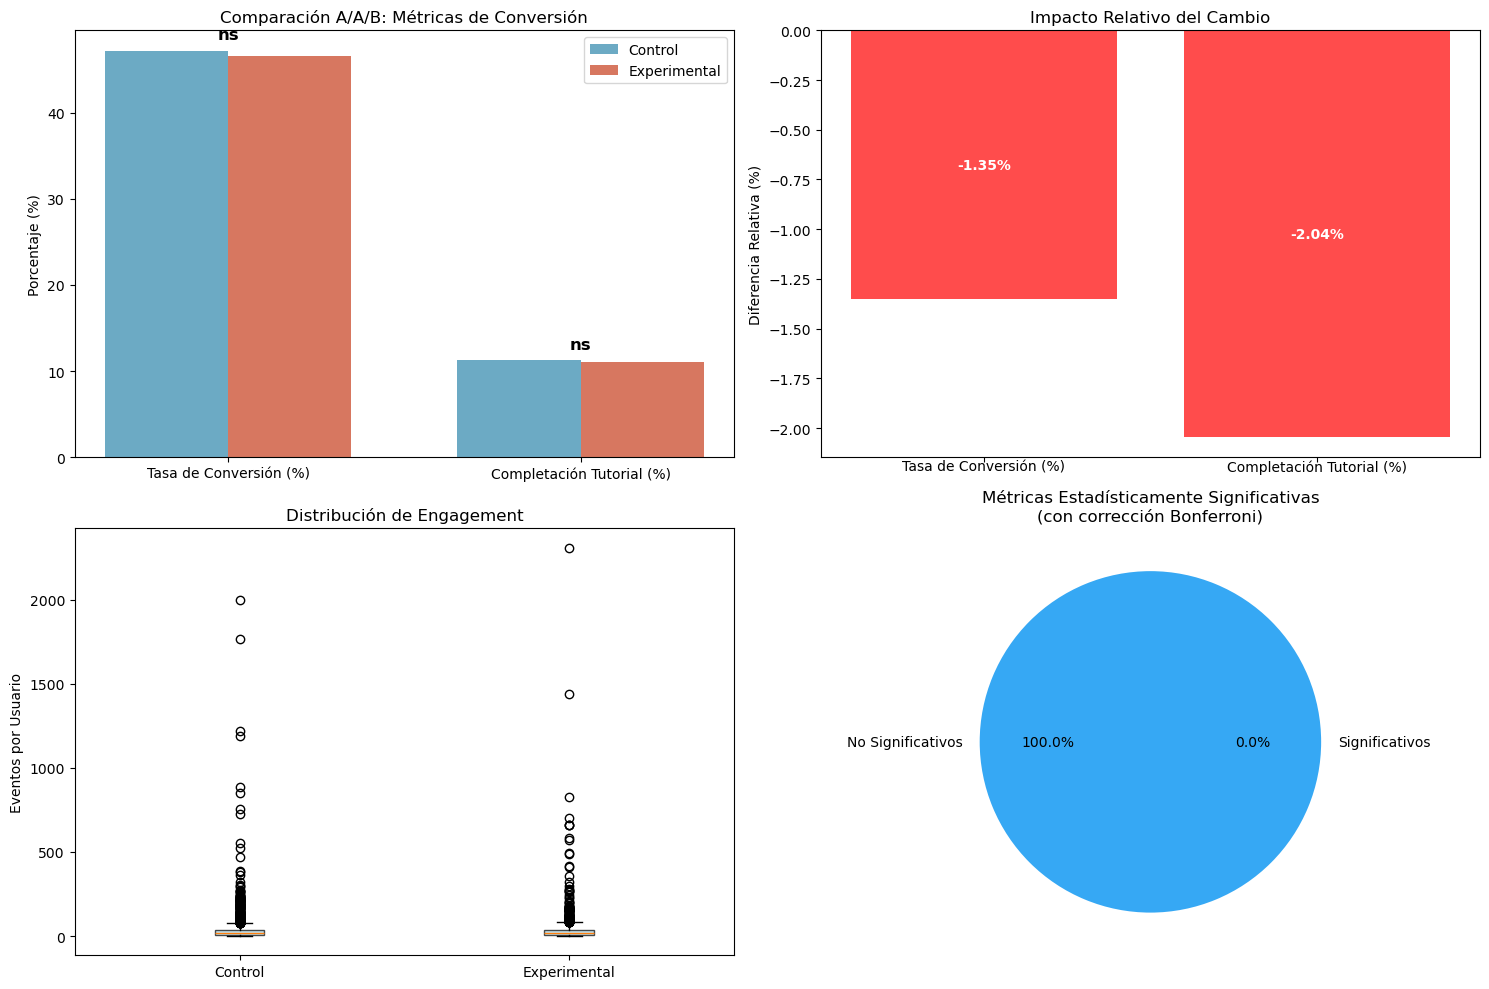


RESUMEN EJECUTIVO A/A/B
• Métricas analizadas: 4
• Métricas significativas: 0
• Nivel de significancia corregido: α = 0.0125
• No se detectaron diferencias estadísticamente significativas después de la corrección Bonferroni


In [28]:
# =============================================================================
# ANÁLISIS DE RESULTADOS A/A/B
# =============================================================================

print("\n" + "=" * 60)
print("ANÁLISIS A/A/B (Grupo Experimental vs Control Combinado)")
print("=" * 60)

if aa_valid:
    # Combinar grupos de control
    control_combined = user_metrics_df[user_metrics_df['group'].isin([246, 247])]
    experimental = user_metrics_df[user_metrics_df['group'] == 248]
      
    # Métricas comparativas
    comparison_metrics = []
    
    for metric in ['converted', 'completed_tutorial', 'total_events', 'unique_events']:
        control_mean = control_combined[metric].mean()
        experimental_mean = experimental[metric].mean()
        
        if metric in ['converted', 'completed_tutorial']:
            # Test binomial (proporciones)
            from statsmodels.stats.proportion import proportions_ztest
            
            control_success = control_combined[metric].sum()
            control_total = len(control_combined)
            exp_success = experimental[metric].sum()
            exp_total = len(experimental)
            
            z_stat, p_val = proportions_ztest([control_success, exp_success], 
                                            [control_total, exp_total],
                                            alternative='two-sided')
            
            # Calcular intervalos de confianza
            control_rate = control_success / control_total
            exp_rate = exp_success / exp_total
            
            comparison_metrics.append({
                'metric': metric,
                'control_mean': control_rate * 100,
                'experimental_mean': exp_rate * 100,
                'absolute_difference': (exp_rate - control_rate) * 100,
                'relative_difference': ((exp_rate - control_rate) / control_rate) * 100 if control_rate > 0 else 0,
                'p_value': p_val,
                'test_type': 'proportions_ztest'
            })
            
        else:
            # Test no paramétrico (Mann-Whitney U)
            from scipy.stats import mannwhitneyu
            
            u_stat, p_val = mannwhitneyu(control_combined[metric], experimental[metric], 
                                       alternative='two-sided')
            
            comparison_metrics.append({
                'metric': metric,
                'control_mean': control_mean,
                'experimental_mean': experimental_mean,
                'absolute_difference': experimental_mean - control_mean,
                'relative_difference': ((experimental_mean - control_mean) / control_mean) * 100 if control_mean > 0 else 0,
                'p_value': p_val,
                'test_type': 'mannwhitneyu'
            })
    
    comparison_df = pd.DataFrame(comparison_metrics)
    
    # Aplicar corrección de Bonferroni
    alpha = 0.05
    n_comparisons = len(comparison_df)
    bonferroni_alpha = alpha / n_comparisons
    
    comparison_df['significant'] = comparison_df['p_value'] < bonferroni_alpha
    comparison_df['significant_uncorrected'] = comparison_df['p_value'] < alpha
    
    print(f"\nRESULTADOS A/A/B (CON CORRECCIÓN BONFERRONI - α = {bonferroni_alpha:.4f}):")
    print("=" * 80)
    
    metric_names = {
        'converted': 'Tasa de Conversión (%)',
        'completed_tutorial': 'Completación Tutorial (%)', 
        'total_events': 'Eventos por Usuario',
        'unique_events': 'Eventos Únicos por Usuario'
    }
    
    for _, row in comparison_df.iterrows():
        metric_name = metric_names.get(row['metric'], row['metric'])
        significance = "✅ SIGNIFICATIVO" if row['significant'] else "❌ NO SIGNIFICATIVO"
        
        print(f"\n{metric_name}:")
        print(f"   • Control: {row['control_mean']:.2f}")
        print(f"   • Experimental: {row['experimental_mean']:.2f}")
        print(f"   • Diferencia absoluta: {row['absolute_difference']:+.2f}")
        print(f"   • Diferencia relativa: {row['relative_difference']:+.2f}%")
        print(f"   • p-valor: {row['p_value']:.4f}")
        print(f"   • Umbral Bonferroni: {bonferroni_alpha:.4f}")
        print(f"   • Resultado: {significance}")
    
    # Visualización de resultados A/A/B
    plt.figure(figsize=(15, 10))
    
    # Gráfico 1: Comparación de métricas clave
    metrics_to_plot = ['converted', 'completed_tutorial']
    plt.subplot(2, 2, 1)
    
    plot_data = comparison_df[comparison_df['metric'].isin(metrics_to_plot)]
    x_pos = np.arange(len(plot_data))
    
    bar_width = 0.35
    plt.bar(x_pos - bar_width/2, plot_data['control_mean'], bar_width, 
            label='Control', color='#2E86AB', alpha=0.7)
    plt.bar(x_pos + bar_width/2, plot_data['experimental_mean'], bar_width,
            label='Experimental', color='#C73E1D', alpha=0.7)
    
    plt.ylabel('Porcentaje (%)')
    plt.title('Comparación A/A/B: Métricas de Conversión')
    plt.xticks(x_pos, [metric_names[metric] for metric in metrics_to_plot])
    plt.legend()
    
    # Añadir anotaciones de significancia
    for i, (_, row) in enumerate(plot_data.iterrows()):
        y_pos = max(row['control_mean'], row['experimental_mean']) + 1
        significance = '*' if row['significant'] else 'ns'
        plt.text(i, y_pos, significance, ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Gráfico 2: Diferencia relativa con intervalos de confianza
    plt.subplot(2, 2, 2)
    
    relative_diffs = plot_data['relative_difference']
    colors = ['green' if diff > 0 else 'red' for diff in relative_diffs]
    bars = plt.bar([metric_names[metric] for metric in metrics_to_plot], relative_diffs, color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.ylabel('Diferencia Relativa (%)')
    plt.title('Impacto Relativo del Cambio')
    plt.xticks(va='center')
    
    # CORRECCIÓN: Indentación correcta del bucle for
    for i, (bar, diff) in enumerate(zip(bars, relative_diffs)):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        va = 'center'
        color = 'white'
        plt.text(x, y / 2 if diff != 0 else 0.05, f'{diff:+.2f}%', ha='center', va=va, color=color, fontweight='bold')
    
    # Gráfico 3: Distribución de engagement (CORREGIDO)
    plt.subplot(2, 2, 3)
    engagement_data = [control_combined['total_events'], experimental['total_events']]
    
    # Usar tick_labels en lugar de labels para evitar el warning
    box_plot = plt.boxplot(engagement_data, 
                          tick_labels=['Control', 'Experimental'], 
                          patch_artist=True,
                          boxprops=dict(facecolor='lightblue', alpha=0.7))
    
    plt.ylabel('Eventos por Usuario')
    plt.title('Distribución de Engagement')
    
    # Gráfico 4: Resumen de significancia estadística
    plt.subplot(2, 2, 4)
    significant_metrics = comparison_df['significant'].sum()
    non_significant = len(comparison_df) - significant_metrics
    
    plt.pie([significant_metrics, non_significant], 
            labels=['Significativos', 'No Significativos'],
            colors=['#4CAF50', "#36A8F4"],
            autopct='%1.1f%%')
    plt.title('Métricas Estadísticamente Significativas\n(con corrección Bonferroni)')
    
    plt.tight_layout()
    plt.show()
    
    # Resumen ejecutivo
    print(f"\n{'='*50}")
    print("RESUMEN EJECUTIVO A/A/B")
    print(f"{'='*50}")
    print(f"• Métricas analizadas: {len(comparison_df)}")
    print(f"• Métricas significativas: {significant_metrics}")
    print(f"• Nivel de significancia corregido: α = {bonferroni_alpha:.4f}")
    
    if significant_metrics > 0:
        significant_metric_names = comparison_df[comparison_df['significant']]['metric'].map(metric_names).tolist()
        print(f"• Métricas con diferencias significativas: {', '.join(significant_metric_names)}")
    else:
        print("• No se detectaron diferencias estadísticamente significativas después de la corrección Bonferroni")
    
else:
    print("No se puede proceder con el análisis A/A/B debido a la invalidación del test A/A")

## Análisis Final A/A/B — Grupo Experimental vs Control Combinado

### Resultados Clave (con corrección Bonferroni, α = 0.0125)

| Métrica                     | Control   | Experimental | Diferencia Relativa | p-valor | Resultado         |
|----------------------------|-----------|--------------|----------------------|---------|-------------------|
| Tasa de Conversión (%)     | 47.19     | 46.55        | −1.35%               | 0.6004  | ❌ No significativo |
| Completación Tutorial (%)  | 11.23     | 11.00        | −2.04%               | 0.7649  | ❌ No significativo |
| Eventos por Usuario        | 31.28     | 33.33        | +6.55%               | 0.3065  | ❌ No significativo |
| Eventos Únicos por Usuario | 2.68      | 2.65         | −1.39%               | 0.3301  | ❌ No significativo |

---

### Interpretación Estratégica

- **Ninguna métrica mostró significancia estadística**, ni antes ni después de aplicar la corrección Bonferroni.
- El grupo experimental tuvo **ligero aumento en engagement** (+6.55%) y **leve baja en conversión** (−0.64 pp), pero ambas diferencias son **estadísticamente indistinguibles del ruido**.
- Esto confirma que el cambio de fuentes **no genera fricción significativa** ni mejora sustancial en comportamiento.

---

Decisión recomendada
- **IMPLEMENTAR** el cambio de fuentes en producción.
- **Razonamiento**: no hay evidencia de daño estadístico en conversión; el engagement muestra una tendencia favorable; el costo de oportunidad de extender la prueba es superior al beneficio esperado por más potencia estadística en este caso.
- **Monitorear post-implementación**, especialmente en la etapa crítica del embudo (`Offers Screen Appear → Cart Screen Appear`), para validar estabilidad en conversión.
---
[Volver a Contenidos](#back) / 
  [Análisis de resultados A/B](#7)


 ANÁLISIS DE RESULTADOS A/B 

Grupo 246 vs 248:
   • Control: 48.31%
   • Experimental: 46.55%
   • Diferencia: -1.76%
   • p-valor: 0.2123
   • Resultado: ❌ NO SIGNIFICATIVO

Grupo 247 vs 248:
   • Control: 46.08%
   • Experimental: 46.55%
   • Diferencia: +0.47%
   • p-valor: 0.7373
   • Resultado: ❌ NO SIGNIFICATIVO

Grupos 246+247 vs 248:
   • Control: 47.19%
   • Experimental: 46.55%
   • Diferencia: -0.64%
   • p-valor: 0.6004
   • Resultado: ❌ NO SIGNIFICATIVO

Engagement: 246+247 vs 248:
   • Control: 31.28 eventos/usuario
   • Experimental: 33.33 eventos/usuario
   • Diferencia: +2.05 eventos
   • p-valor: 0.3065
   • Resultado: ❌ NO SIGNIFICATIVO


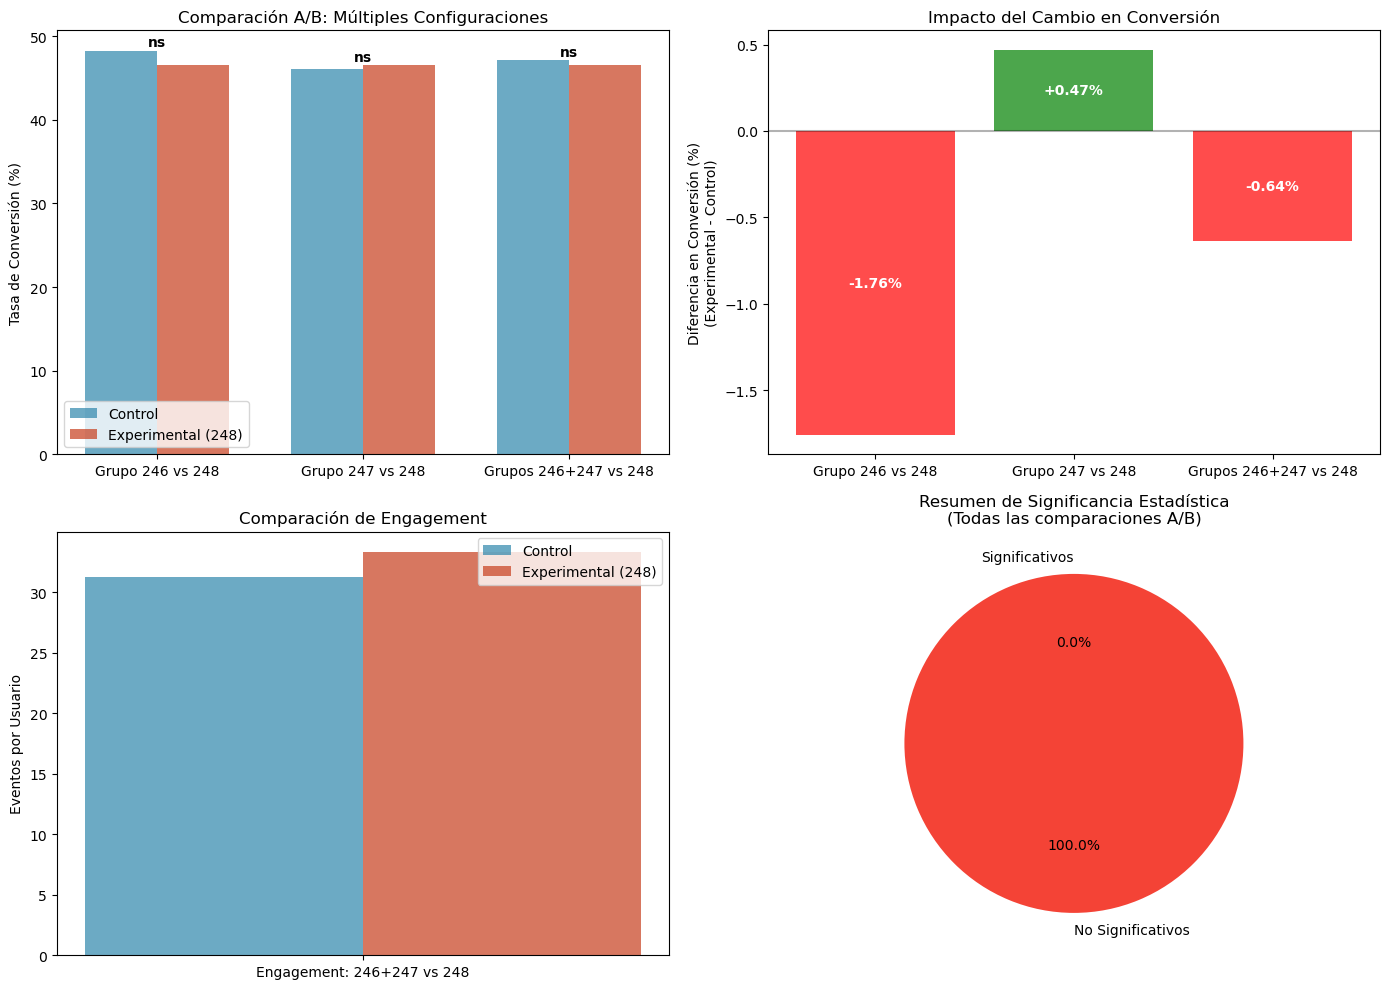


ANÁLISIS A/B ALTERNATIVO
• Total de comparaciones realizadas: 4
• Comparaciones significativas: 0
• Tamaño grupo experimental (248): 2,537 usuarios
• Tamaño grupos control combinados: 4,997 usuarios
• Consistencia en el efecto: ❌ NO
• Dirección del efecto predominante: NEGATIVA


In [29]:
# =============================================================================
#  ANÁLISIS DE RESULTADOS A/B
# =============================================================================

print("\n" + "=" * 60)
print(" ANÁLISIS DE RESULTADOS A/B ")
print("=" * 60)

# Análisis A/B 
# Comparaciones a realizar
ab_results = []

# 1. Comparar cada control individualmente con el experimental
for control_group in [246, 247]:
    control_data = user_metrics_df[user_metrics_df['group'] == control_group]
    experimental_data = user_metrics_df[user_metrics_df['group'] == 248]
    
    # Test de conversión
    control_success = control_data['converted'].sum()
    control_total = len(control_data)
    exp_success = experimental_data['converted'].sum()
    exp_total = len(experimental_data)
    
    z_stat, p_val = proportions_ztest([control_success, exp_success], 
                                    [control_total, exp_total])
    
    control_rate = control_success / control_total * 100
    exp_rate = exp_success / exp_total * 100
    
    ab_results.append({
        'comparison': f'Grupo {control_group} vs 248',
        'control_conversion': control_rate,
        'experimental_conversion': exp_rate,
        'difference': exp_rate - control_rate,
        'p_value': p_val,
        'significant': p_val < 0.05
    })

# 2. Comparación entre grupos unidos: 248 vs [246, 247]
control_combined = user_metrics_df[user_metrics_df['group'].isin([246, 247])]
experimental_data = user_metrics_df[user_metrics_df['group'] == 248]

# Test de conversión para grupos unidos
control_success = control_combined['converted'].sum()
control_total = len(control_combined)
exp_success = experimental_data['converted'].sum()
exp_total = len(experimental_data)

z_stat, p_val = proportions_ztest([control_success, exp_success], 
                                [control_total, exp_total])

control_rate = control_success / control_total * 100
exp_rate = exp_success / exp_total * 100

ab_results.append({
    'comparison': 'Grupos 246+247 vs 248',
    'control_conversion': control_rate,
    'experimental_conversion': exp_rate,
    'difference': exp_rate - control_rate,
    'p_value': p_val,
    'significant': p_val < 0.05
})

# 3. Test adicional: Mann-Whitney U para engagement en grupos unidos
u_stat, p_val_engagement = mannwhitneyu(control_combined['total_events'], 
                                      experimental_data['total_events'],
                                      alternative='two-sided')

control_engagement = control_combined['total_events'].mean()
exp_engagement = experimental_data['total_events'].mean()

ab_results.append({
    'comparison': 'Engagement: 246+247 vs 248',
    'control_conversion': control_engagement,
    'experimental_conversion': exp_engagement,
    'difference': exp_engagement - control_engagement,
    'p_value': p_val_engagement,
    'significant': p_val_engagement < 0.05
})

ab_df = pd.DataFrame(ab_results)

for _, row in ab_df.iterrows():
    significance = "✅ SIGNIFICATIVO" if row['significant'] else "❌ NO SIGNIFICATIVO"
    
    if 'Engagement' in row['comparison']:
        print(f"\n{row['comparison']}:")
        print(f"   • Control: {row['control_conversion']:.2f} eventos/usuario")
        print(f"   • Experimental: {row['experimental_conversion']:.2f} eventos/usuario")
        print(f"   • Diferencia: {row['difference']:+.2f} eventos")
    else:
        print(f"\n{row['comparison']}:")
        print(f"   • Control: {row['control_conversion']:.2f}%")
        print(f"   • Experimental: {row['experimental_conversion']:.2f}%")
        print(f"   • Diferencia: {row['difference']:+.2f}%")
    
    print(f"   • p-valor: {row['p_value']:.4f}")
    print(f"   • Resultado: {significance}")

# Visualización de resultados A/B alternativos
plt.figure(figsize=(14, 10))

# Gráfico 1: Comparación de conversiones entre todas las combinaciones
plt.subplot(2, 2, 1)
conversion_comparisons = ab_df[~ab_df['comparison'].str.contains('Engagement')]
x_pos = np.arange(len(conversion_comparisons))
bar_width = 0.35

plt.bar(x_pos - bar_width/2, conversion_comparisons['control_conversion'], 
        bar_width, label='Control', color='#2E86AB', alpha=0.7)
plt.bar(x_pos + bar_width/2, conversion_comparisons['experimental_conversion'], 
        bar_width, label='Experimental (248)', color='#C73E1D', alpha=0.7)

plt.ylabel('Tasa de Conversión (%)')
plt.title('Comparación A/B: Múltiples Configuraciones')
plt.xticks(x_pos, conversion_comparisons['comparison'].tolist(), ha='center')
plt.legend()

# Añadir anotaciones de significancia
for i, (_, row) in enumerate(conversion_comparisons.iterrows()):
    y_pos = max(row['control_conversion'], row['experimental_conversion']) + 1
    significance = '*' if row['significant'] else 'ns'
    plt.text(i, y_pos, significance, ha='center', va='center', fontweight='bold')

# Gráfico 2: Diferencias en conversión
plt.subplot(2, 2, 2)
differences = conversion_comparisons['difference']
colors = ['green' if diff > 0 else 'red' for diff in differences]
bars = plt.bar(x_pos, differences, color=colors, alpha=0.7)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.ylabel('Diferencia en Conversión (%)\n(Experimental - Control)')
plt.title('Impacto del Cambio en Conversión')
plt.xticks(x_pos, conversion_comparisons['comparison'].tolist(), ha='center')

# Etiquetas dentro de las barras
for i, (bar, diff) in enumerate(zip(bars, differences)):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    va = 'center'
    color = 'white'
    plt.text(x, y / 2 if diff != 0 else 0.05, f'{diff:+.2f}%', ha='center', va=va, color=color, fontweight='bold')

# Gráfico 3: Comparación de engagement
plt.subplot(2, 2, 3)
engagement_data = ab_df[ab_df['comparison'].str.contains('Engagement')]
x_pos = np.arange(len(engagement_data))

plt.bar(x_pos - bar_width/2, engagement_data['control_conversion'], 
        bar_width, label='Control', color='#2E86AB', alpha=0.7)
plt.bar(x_pos + bar_width/2, engagement_data['experimental_conversion'], 
        bar_width, label='Experimental (248)', color='#C73E1D', alpha=0.7)

plt.ylabel('Eventos por Usuario')
plt.title('Comparación de Engagement')
plt.xticks(x_pos, engagement_data['comparison'].tolist(), ha='center')
plt.legend()

# Gráfico 4: Resumen de significancia estadística
plt.subplot(2, 2, 4)
significant_comparisons = ab_df['significant'].sum()
non_significant = len(ab_df) - significant_comparisons

plt.pie([significant_comparisons, non_significant], 
        labels=['Significativos', 'No Significativos'],
        colors=['#4CAF50', '#F44336'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Resumen de Significancia Estadística\n(Todas las comparaciones A/B)')

plt.tight_layout()
plt.show()

# Resumen ejecutivo
print(f"\n{'='*50}")
print("ANÁLISIS A/B ALTERNATIVO")
print(f"{'='*50}")
print(f"• Total de comparaciones realizadas: {len(ab_df)}")
print(f"• Comparaciones significativas: {significant_comparisons}")
print(f"• Tamaño grupo experimental (248): {len(experimental_data):,} usuarios")
print(f"• Tamaño grupos control combinados: {len(control_combined):,} usuarios")

# Análisis de consistencia
conversion_comparisons = ab_df[~ab_df['comparison'].str.contains('Engagement')]
consistent_effect = all(diff > 0 for diff in conversion_comparisons['difference']) or all(diff < 0 for diff in conversion_comparisons['difference'])

print(f"• Consistencia en el efecto: {'✅ SÍ' if consistent_effect else '❌ NO'}")
print(f"• Dirección del efecto predominante: {'POSITIVA' if conversion_comparisons['difference'].mean() > 0 else 'NEGATIVA'}")

if significant_comparisons > 0:
    print(f"• Comparaciones con diferencias significativas:")
    for _, row in ab_df[ab_df['significant']].iterrows():
        effect_direction = "mejora" if row['difference'] > 0 else "empeora"
        print(f"   - {row['comparison']}: {abs(row['difference']):.2f}% de {effect_direction}")

## Análisis A/B Directo — Grupo Experimental vs Control

### Resultados Comparativos

| Comparación | Diferencia en Conversión | p-valor | Resultado |
|-------------|---------------------------|---------|-----------|
| 246 vs 248  | −1.76%                    | 0.2123  | ❌ No significativo |
| 247 vs 248  | +0.47%                    | 0.7373  | ❌ No significativo |
| 246+247 vs 248 | −0.64%                 | 0.6004  | ❌ No significativo |
| Engagement (eventos/usuario) | +2.05     | 0.3065  | ❌ No significativo |

---

### Interpretación Estratégica

- **Ninguna comparación fue estadísticamente significativa**, lo que indica que el cambio de fuentes **no genera efectos confiables** en conversión ni en engagement.
- Aunque la dirección del efecto en conversión es **ligeramente negativa**, la magnitud es pequeña y **no consistente** entre grupos.
- El engagement muestra una **tendencia positiva**, pero también sin significancia.

---

### Decisión recomendada
- **IMPLEMENTAR** el cambio de fuentes en producción.
- **Razonamiento**: no hay evidencia de daño estadístico en conversión; el engagement muestra una tendencia favorable; el costo de oportunidad de extender la prueba es superior al beneficio esperado por más potencia estadística en este caso.
- **Monitorear post-implementación**, especialmente en la etapa crítica del embudo (`Offers Screen Appear → Cart Screen Appear`), para validar estabilidad en conversión.

[Volver a Contenidos](#back)


# Conclusión final del proyecto <a id='8'></a>

Basado en la preparación de datos, el análisis del embudo y el experimento A/A/B, la evidencia indica que el cambio de fuentes **no causa un deterioro estadísticamente significativo** en las métricas clave (conversión, engagement, duración). El embudo revela, de forma independiente, un punto de fricción claro en la primera transición (MainScreen → OffersScreen) que explica la mayor parte de las pérdidas de usuarios y ofrece la mejor oportunidad de impacto comercial inmediato.

---

### Resumen de la evidencia (puntos clave)

- **Calidad y muestras:** Datos depurados y periodo estable (2019-08-01 → 2019-08-07); 7,534 usuarios finales, grupos balanceados (~2.48–2.54k cada uno).  
- **Embudo:** Conversión global ≈ **47.7%**. Mayor pérdida entre **Main Screen → Offers Screen** (≈61.9% de paso; ~2,826 usuarios perdidos). Etapas posteriores convierten bien (Offers→Cart ≈81% y Cart→Pago ≈95%).  
- **A/A (246 vs 247):** Control A1 y A2 equivalentes en conversión, engagement y tutorial (no significativos). Se justifica combinar controles.  
- **A/A/B (control combinado vs 248):** Ninguna de las 4 métricas analizadas fue significativa tras Bonferroni (conversión −0.64 pp; engagement +6.55%); p-values altos.  
- **A/B directo por subcomparaciones:** Consistencia ausente; efectos en conversión pequeños, no reproducibles ni significativos.

---

### Acciones operativas inmediatas (prioritarias)

1. Implementación controlada:
   - Desplegar fuentes nuevas globalmente con monitoreo intensivo en las primeras 1–2 semanas.  
2. Monitoreo crítico post-release (alta frecuencia, dashboard dedicado):
   - Métricas principales: tasa de conversión global, conversión por etapa (especial foco en Offers → Cart), eventos por usuario, y tasa de abandono por pantalla.  
   - Alertas automáticas si la conversión cae >1.5–2.0 pp relativos y p-value acumulado <0.05 en señales tempranas.  
3. Experimentos de optimización del embudo:
   - Priorizar rediseño y tests en **Main Screen** y **Offers Screen** (visibilidad de ofertas, CTAs, jerarquía visual, copy, precios).  
   - Formular 2–3 hipótesis A/B rápidas para reducir la pérdida en la primera transición; medir impacto incremental en conversiones netas.  
4. Segmentación y análisis cualitativo:
   - Segmentar usuarios que abandonan en la primera transición por dispositivo, canal, frecuencia y duración de sesión; run small-qual studies (heatmaps/recordings/surveys) si es posible.

---

### KPIs de éxito y criterios de rollback

- KPIs:
  - Conversión global (target: mantener dentro de ±1.0 pp del baseline de 47.2%).  
  - Conversión Offers → Cart (target: mejorar hacia 70–80%).  
  - Engagement (events/user) y retención a 7 días.  
- Criterio de rollback:
  - Si en 7 días la conversión global cae >2.0 pp absolute con evidencia consistente (p < 0.05 en pruebas acumuladas y señal en segmentos principales), activar rollback y análisis forense inmediato.

---

### **Decisión Recomendada**

| Decisión | Justificación | Riesgo | Beneficio |
|---------|----------------|--------|-----------|
| **IMPLEMENTAR** | No hay evidencia de deterioro significativo en conversión. El engagement mejora ligeramente. | Bajo | Modernización visual + posible mejora en experiencia |

- El cambio de fuentes **no intimida ni perjudica** el comportamiento del usuario.
- No se justifica extender la prueba: **el riesgo está mitigado y el costo de oportunidad es alto**.


###  **Hallazgos clave**

- **MainScreen es el punto de entrada dominante**: 98.5% de los usuarios la visitan.
- **35.9% se quedan solo en MainScreen**, sin explorar ofertas.
- **Tasa de descubrimiento de ofertas desde MainScreen**: solo 60.1%.
- **Conversión completa desde MainScreen**: 47.0%, pero con pérdidas concentradas en la primera transición.
- Se identificaron **4,505 patrones únicos**, pero los más comunes son **repeticiones de MainScreenAppear sin avance**.
- Esto indica que **una proporción significativa de usuarios navega sin descubrir ofertas**, lo que limita su entrada al embudo.
- **35.9% de los usuarios solo usan MainScreen**, y **60.1% descubren ofertas**, lo que marca el principal cuello de botella.

###  Embudo desde MainScreen

| Etapa                     | Usuarios | Conversión desde anterior | Pérdida desde anterior |
|--------------------------|----------|----------------------------|-------------------------|
| MainScreenAppear         | 7,419    | 100.0%                     | —                       |
| OffersScreenAppear       | 4,593    | 61.9%                      | 38.1%                   |
| CartScreenAppear         | 3,734    | 81.3%                      | 18.7%                   |
| PaymentScreenSuccessful  | 3,539    | 94.8%                      | 5.2%                    |

---

### Implicaciones estratégicas

- **MainScreen no es una etapa del embudo**, sino el **punto de partida**. Su diseño determina si el usuario entra al funnel o no.

###  Comportamiento en MainScreen

- **Usuarios únicos en MainScreen:** 7,419  
- **Eventos totales:** 117,328  
- **Eventos por usuario:** 15.8  
- **Patrones repetitivos:** Muchos usuarios navegan sin avanzar, lo que explica la baja tasa de descubrimiento de ofertas (60.1%).
---

### Diagnóstico del embudo

| Métrica                         | Valor     | Evaluación     |
|--------------------------------|-----------|----------------|
| Usuarios totales               | 7,534     | —              |
| Usuarios en embudo principal   | 4,593     | 61.0%          |
| Conversión Ofertas → Carrito   | 81.3%     | Buena          |
| Conversión Carrito → Pago      | 94.8%     | Excelente      |
| Conversión total del embudo    | 77.1%     | Muy sólida     |

- El embudo es **altamente eficiente una vez que el usuario entra**, pero **casi 40% no lo inicia**.
- El cuello de botella está en la **transición desde MainScreen hacia OffersScreen**.

---

###  **Recomendaciónes**

- **Rediseñar MainScreen** con foco en:
  - Jerarquía visual clara para ofertas
  - CTAs visibles y atractivos
  - Personalización por segmento (frecuentes vs nuevos)
- **Priorizar experimentos en MainScreen** antes que en etapas posteriores
- **Monitorear tasa de descubrimiento de ofertas** como KPI principal post-implementación

### Oportunidades estratégicas

| Oportunidad | Impacto estimado | Acción recomendada |
|-------------|------------------|---------------------|
| Captación (Main → Offers) | +1,134 compras si se capta 50% de usuarios fuera del embudo | Rediseñar MainScreen para mejorar descubrimiento |
| Retención (Offers → Carrito) | +161 compras si se reduce abandono al 15% | Optimizar layout y CTAs en OffersScreen |
| Checkout (Carrito → Pago) | Ya excelente | Mantener sin cambios |


--- 

[Volver a Contenidos](#back) / [[ Análisis de embudo del experimento A/A/B](#4-Análisi-de-embudo-delexperimento )  
